# Substitution

In [34]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

## Raw Data

### Uricchio et al. Data

In [36]:
plt.show()

In [37]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Load B and R Maps

In [38]:
ratchet_pkl = '../data/bmaps/bgspy/bmap_hg37_ratchet_10000step_10000N_cds_utrs_phastcons.pkl'
ratchet_m = BGSModel.load(ratchet_pkl)

In [39]:
ratchet_m

In [276]:
import pickle
mm = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))

/home/vsb/projects/bprime/bgspy/likelihood.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [278]:
mm[0], mm[1]

(MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-likelihood: 916117190701.985
 π0 = 0.001804663644383997
 R² = 62.421
 W = 
           cds    phastcons    utr
 ------  -----  -----------  -----
 1e-07   0            0      0.001
 1e-06   0.001        0      0.001
 1e-05   0.001        0      0.004
 0.0001  0.002        0.001  0.083
 0.001   0.007        0.162  0.016
 0.01    0.008        0.485  0.658
 0.1     0.981        0.35   0.236
 μ = 
         cds    phastcons          utr
 -----------  -----------  -----------
 2.14119e-08  2.77184e-08  8.07999e-09,
 MLE (interpolated w): 6 x 7 x 3
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
 
 Free-mutation model ML estimates:
 negative log-li

In [281]:
mm[1].mle_W

array([[7.04413952e-10, 3.04018667e-10, 4.89589415e-08],
       [1.15786776e-08, 1.44146424e-09, 5.82155003e-08],
       [5.94789366e-10, 9.18528013e-11, 2.27448527e-10],
       [1.70349273e-11, 1.26404530e-11, 6.90188330e-10],
       [1.94413391e-10, 5.54691174e-09, 3.65840166e-09],
       [2.60608165e-11, 1.21792277e-08, 2.93827847e-11],
       [1.00152998e-09, 1.25873516e-08, 1.08961439e-08]])

## PhyloFit Branch Length Estimates

In [40]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)

In [41]:
p.head()

,chrom,start,end,branch_length,bl_nbases
0,chr1,1059994,1095749,0.010402,72265
1,chr1,1283738,1308299,0.006782,52319
2,chr1,1564773,1623511,0.010483,178850
3,chr1,1626991,1655940,0.006026,63570
4,chr1,1752959,1789083,0.008125,86103


[]

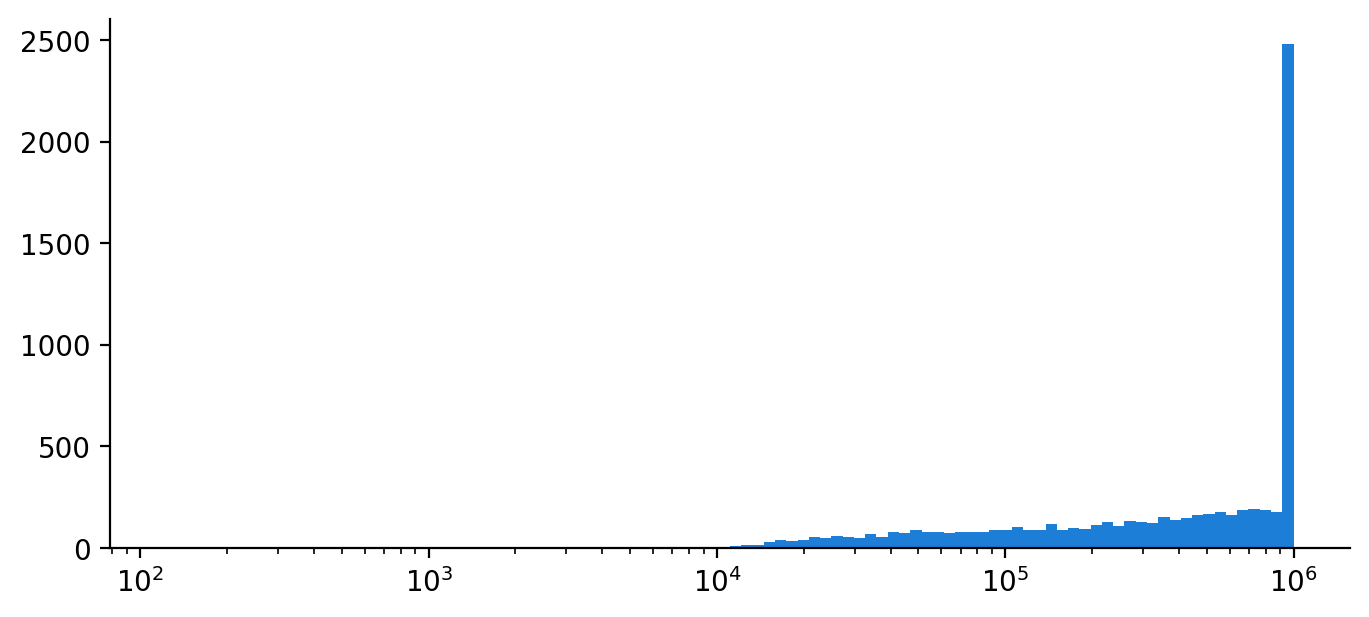

In [42]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [43]:
p['bl_nbases'].max()

1000000

## Analysis of Predicted Ratchet Rates for CDS/UTRS/PhastCons Model

In [233]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    "r",
    "r_nbases",
    "branch_length",
    "bl_nbases",
]

d = pd.read_csv('../data/phylo/urrichio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']

In [234]:
d.head()

,chrom,start,end,gene_id,n_nonsyn,n_syn,fixed_nonsyn,fixed_syn,dnDs,total_fixed,...,gc3,syn_prop,nonsyn_prop,total_prop,dNdS,r,r_nbases,branch_length,bl_nbases,width
0,chr1,923923,944575,ENSG00000187634,28,21,8,4,2.000000,12,...,0.832938,0.001580,0.003160,0.004739,2.000000,3.414758e-07,4658,NaN,NaN,20652
1,chr1,944203,959309,ENSG00000188976,31,32,4,8,0.500000,12,...,0.794393,0.003560,0.001780,0.005340,0.500000,3.414794e-07,2950,NaN,NaN,15106
2,chr1,960584,965719,ENSG00000187961,11,28,0,8,0.000000,8,...,0.838006,0.004154,0.000000,0.004154,0.000000,3.418007e-07,2776,NaN,NaN,5135
3,chr1,966482,975865,ENSG00000187583,47,19,0,3,0.000000,3,...,0.801964,0.001637,0.000000,0.001637,0.000000,3.414197e-07,3800,NaN,NaN,9383
4,chr1,975198,982117,ENSG00000187642,31,22,11,3,3.666667,14,...,0.681013,0.001266,0.004641,0.005907,3.666667,3.413790e-07,4203,NaN,NaN,6919


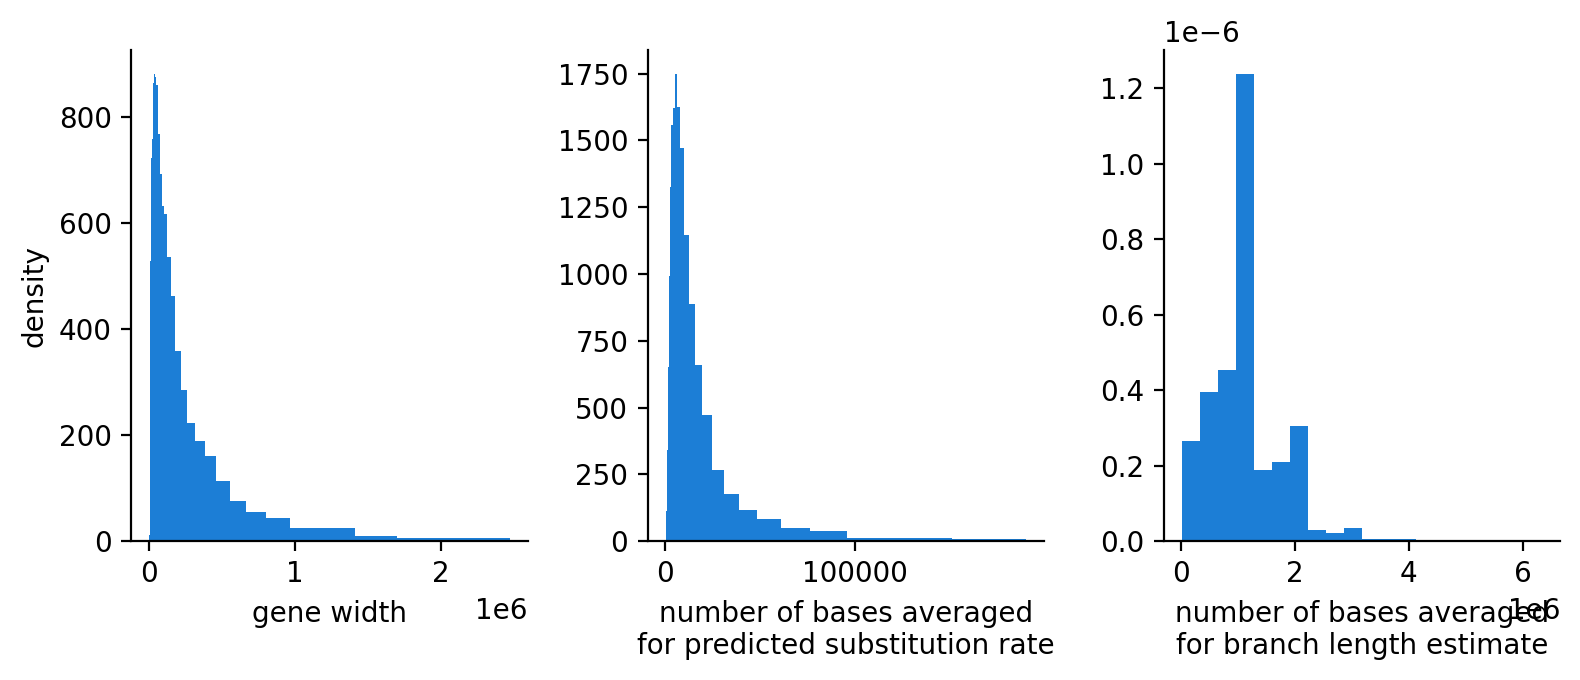

In [235]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

In [236]:
d['bl_nbases'].max()

6336248.0

Text(0.5, 0, 'predicted substitution rate')

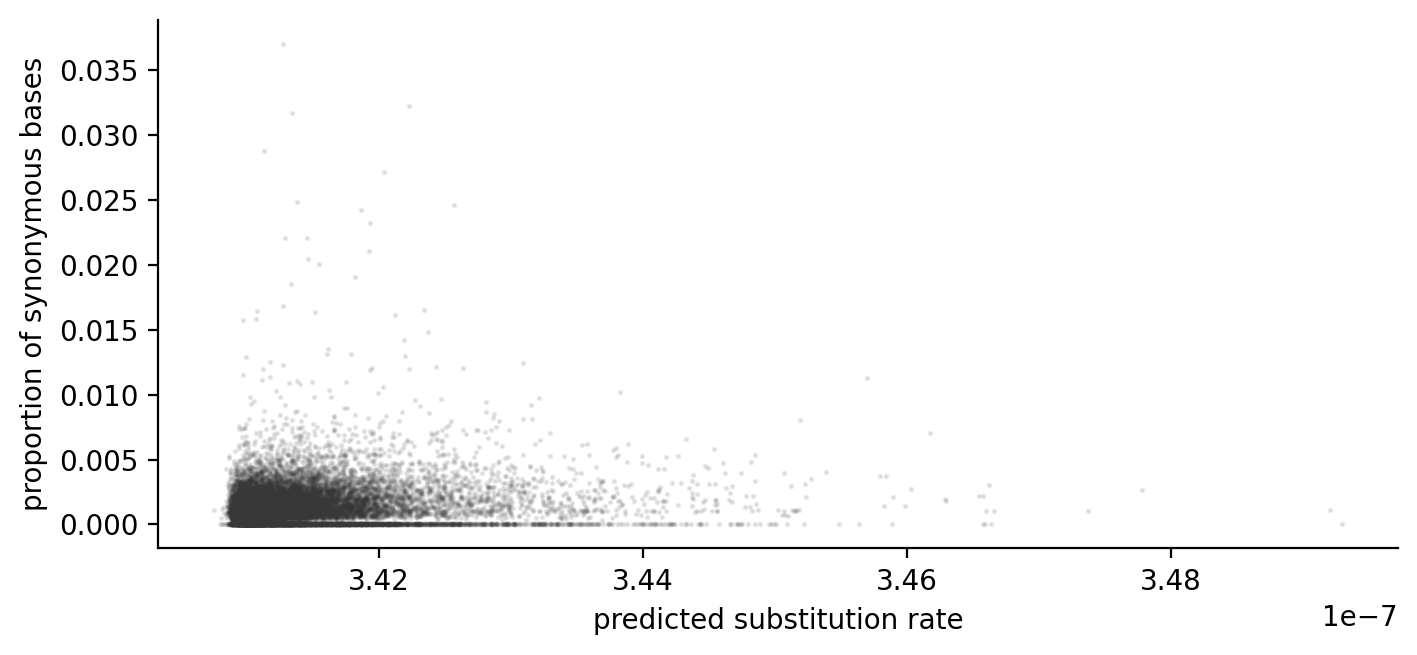

In [237]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=0.1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

In [238]:
ax.get_xlim(), ax.get_ylim()

((3.4032236298000003e-07, 3.4972267521999997e-07),
 (-0.0018518518518518502, 0.03888888888888885))

In [239]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [271]:
x, syn_prop, nonsyn_prop, branch_length = d['r'], d['syn_prop'], d['nonsyn_prop'], d['branch_length']

nbins = 100
dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ErrorbarContainer object of 3 artists>

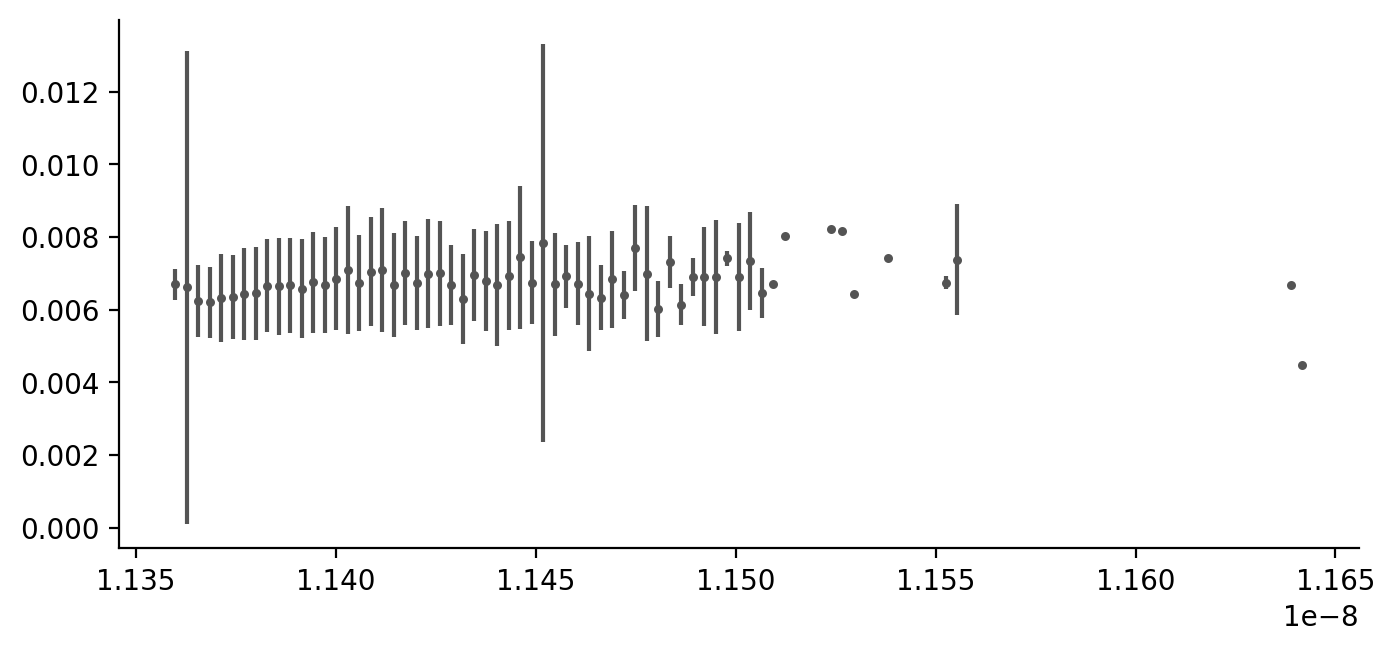

In [275]:
fig, ax = plt.subplots()
T = 1 / 30

error_col = '0.33'
ax.scatter(dbl['midpoint']*T, dbl['mean'], c=error_col, s=5)
ax.errorbar(dbl['midpoint']*T, dbl['mean'], dbl['sd'], fmt='none', c=error_col)
#ax.set_xlim(ax.get_xlim()[0], 3.44e-7)

(0.0, 0.002)

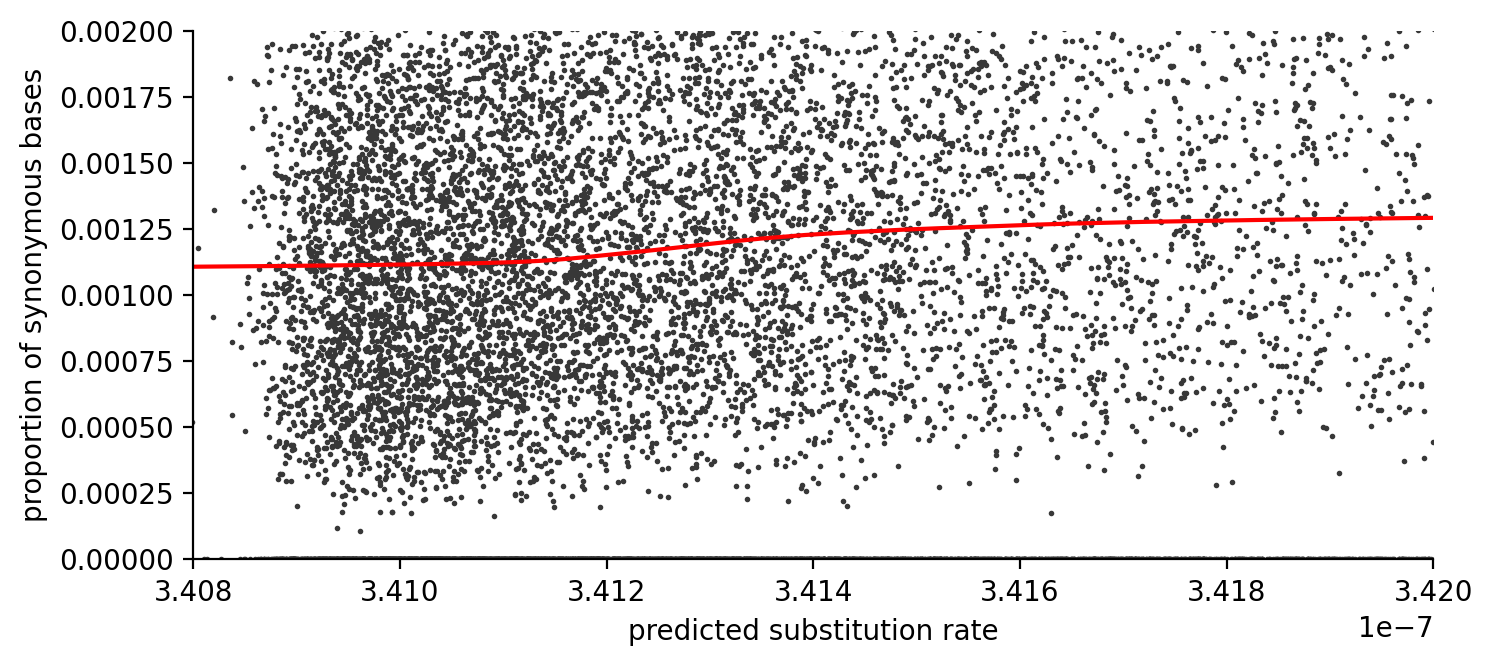

In [90]:
fig, ax = plt.subplots()
ax.plot(*syn_lw.T, c='r')

ax.scatter(x, y, c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

ax.set_xlim(3.408e-7, 3.42e-7)
ax.set_ylim(0.00, 0.002)

ERROR! Session/line number was not unique in database. History logging moved to new session 2355


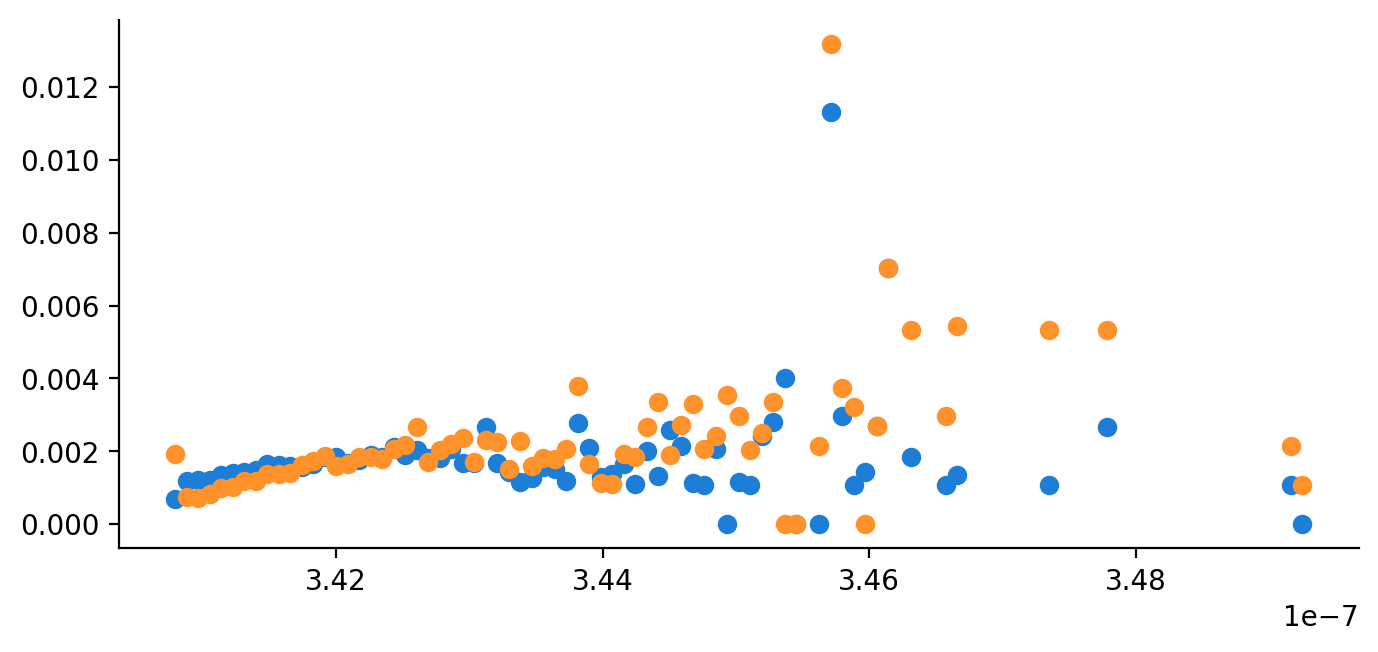

In [104]:
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, 100))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, 100))))

In [225]:
dns = binned_summaries(x, nonsyn_prop, 200)
ds = binned_summaries(x, syn_prop, 200)
dbl = binned_summaries(x, branch_length, 200)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


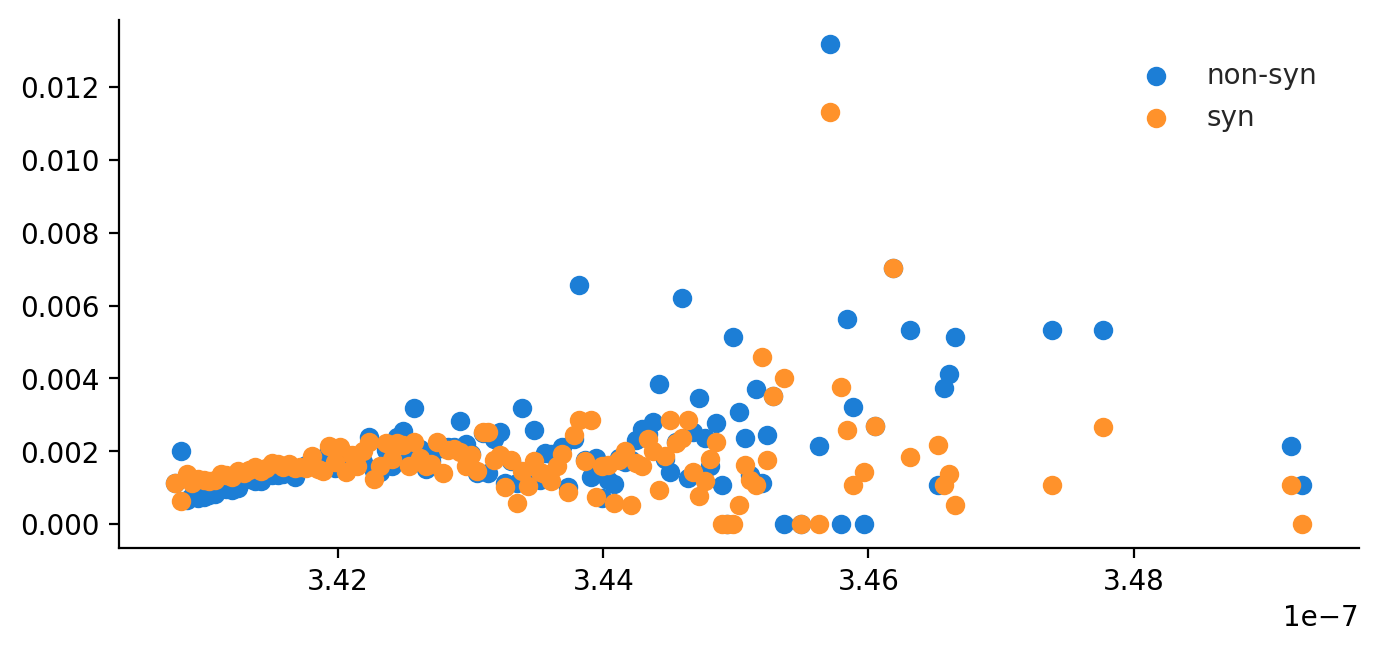

In [226]:
min_n = 0

dnsx = dns.loc[dns['n'] > min_n]
plt.scatter(dnsx['midpoint'], dnsx['mean'], label='non-syn')

dsx = ds.loc[ds['n'] > min_n]
plt.scatter(dsx['midpoint'], dsx['mean'], label='syn')

syn_lw = lowess(syn_prop, x, frac=1/50)
#plt.plot(*syn_lw.T)

plt.legend()

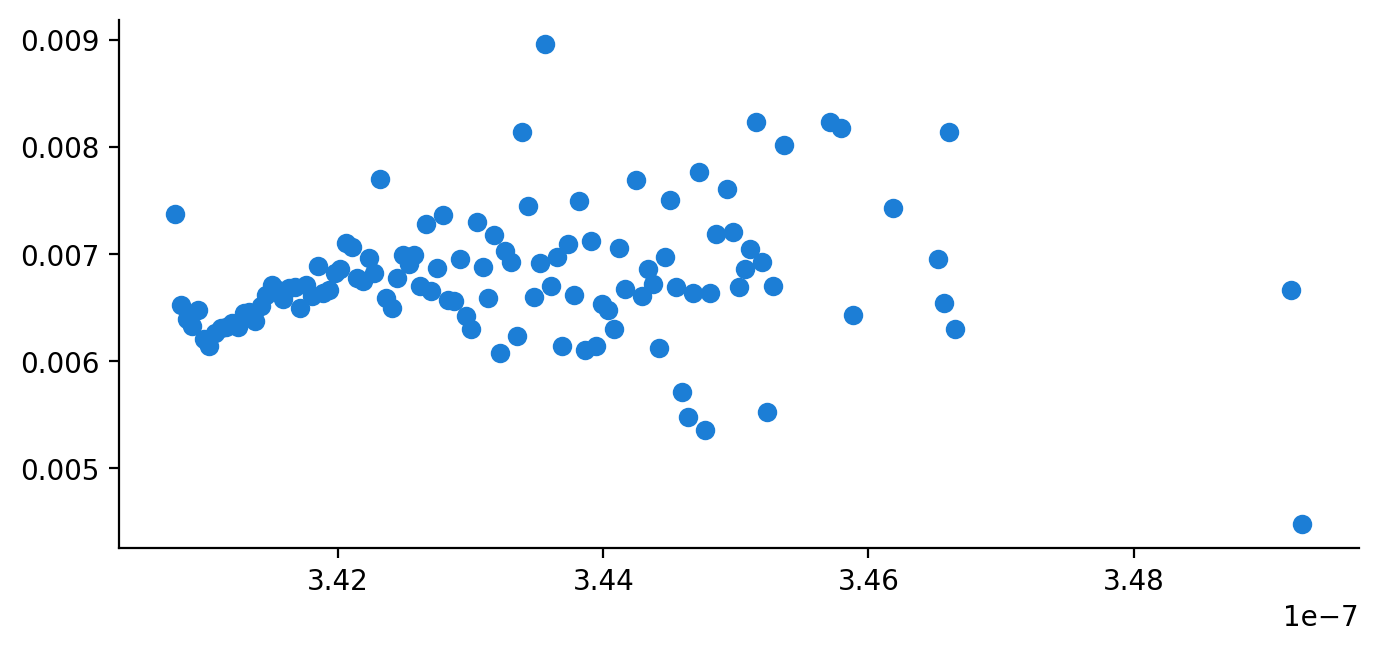

In [227]:
dblx = dbl.loc[dbl['n'] > min_n]
plt.scatter(dblx['midpoint'], dblx['mean'])

$$
S = \lambda_g t_y g
$$



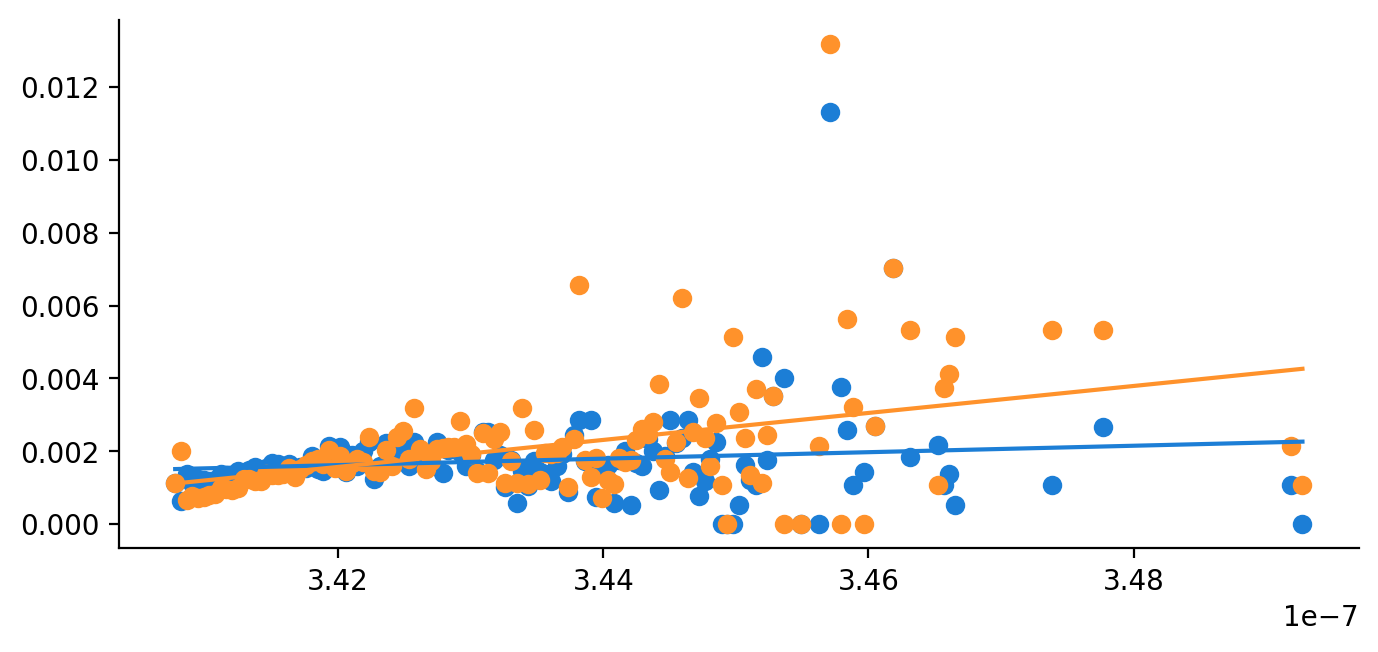

In [228]:
syn_lfit = stats.linregress(dsx['midpoint'], dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint'], dnsx['mean'])

plt.scatter(dsx['midpoint'], dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)
plt.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

plt.scatter(dnsx['midpoint'], dnsx['mean'], label='non-syn')
plt.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)


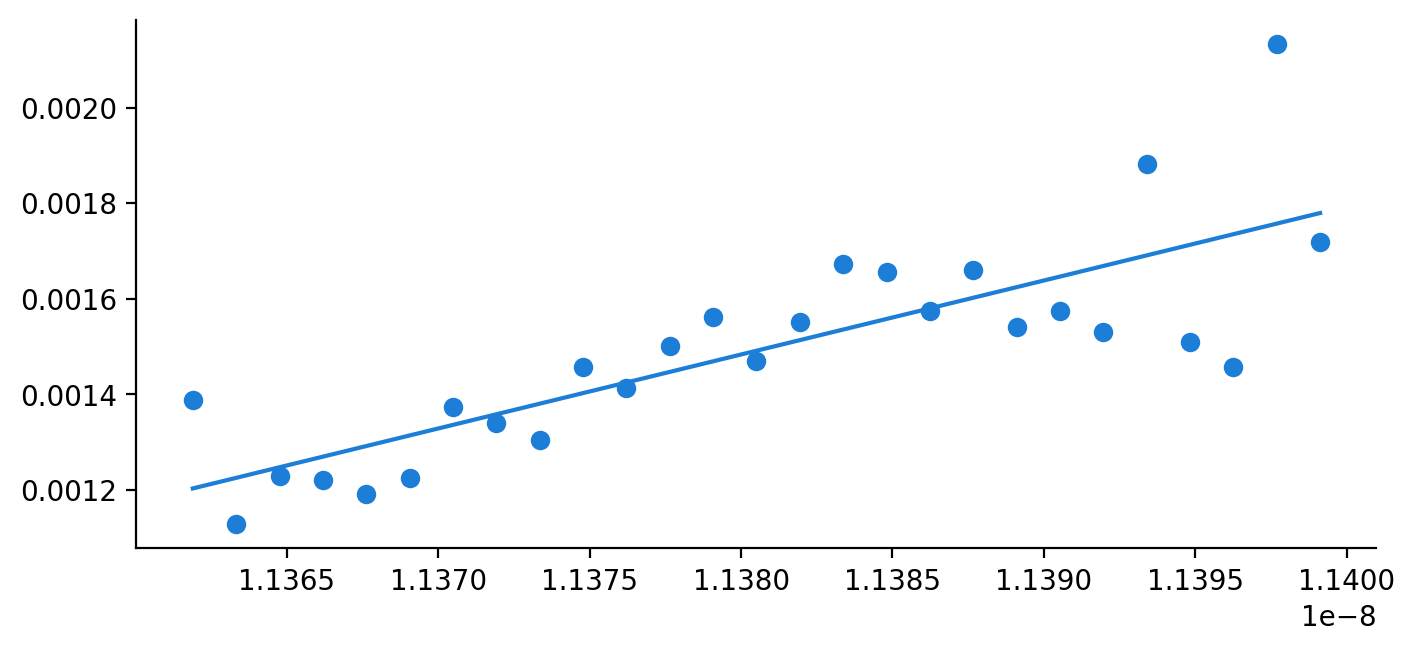

In [230]:
gen_time = 30 # years / gen 


d = ds
dx = d.loc[(d['n'] > 30) & (d['midpoint'] < 3.42e-7)]

#dx = d.loc[(d['n'] > 30) & (d['midpoint'] < 3.5e-7) & (d['midpoint'] > 3.409e-7)]
midpoint_gen = dx['midpoint'] / gen_time



bl_lfit = stats.linregress(midpoint_gen, dx['mean'])


plt.scatter(midpoint_gen, dx['mean'], label='syn')

rate_grid = np.linspace(midpoint_gen.min(), midpoint_gen.max(), 100)

plt.plot(rate_grid, rate_grid*bl_lfit.slope + bl_lfit.intercept)

In [231]:
bl_lfit

LinregressResult(slope=15487471.198826086, intercept=-0.17476423417405323, rvalue=0.8000014945811807, pvalue=5.503425605762209e-07, stderr=2323108.623949857, intercept_stderr=0.02643817150259988)

In [208]:
bl_lfit.slope

2315433.0717009567

In [ ]:
def JC69(r, t):
    # distance
    return r * t
    #return 0.75 - 0.75*np.exp(-4/3 * r*t)


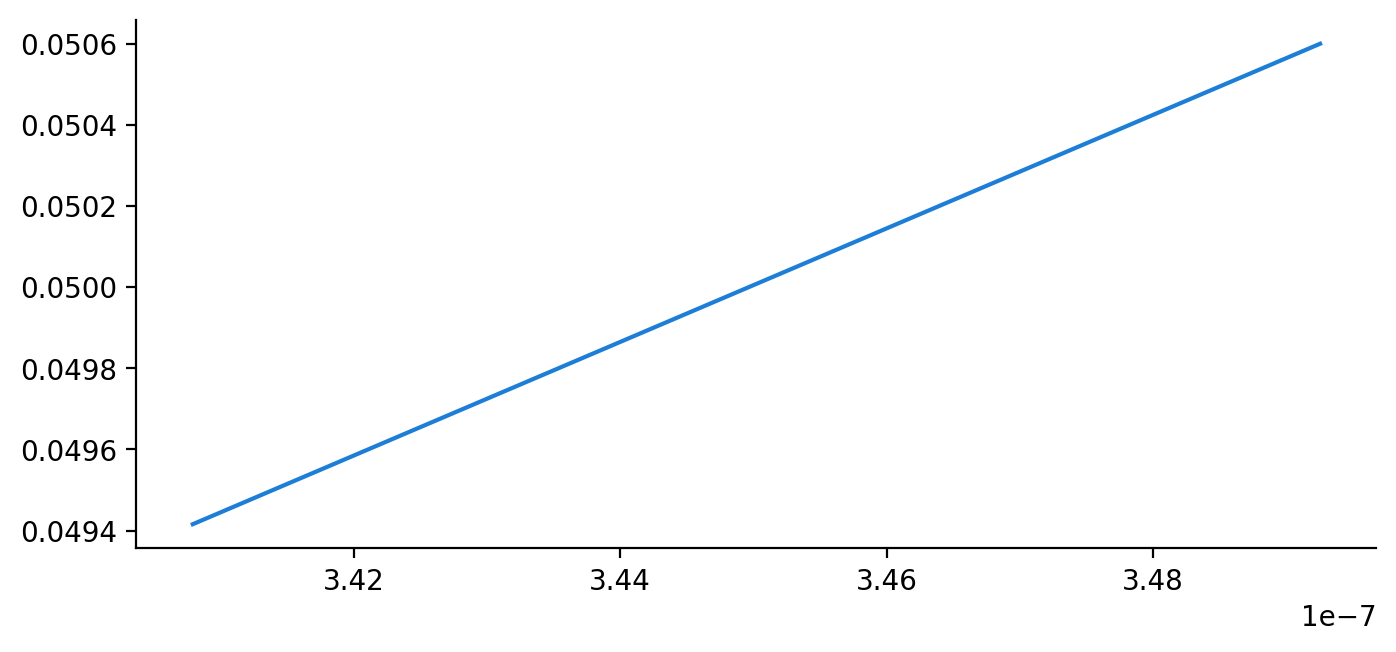

In [175]:
plt.plot(rate_grid, JC69(rate_grid, 4.5e6 / 30))

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))


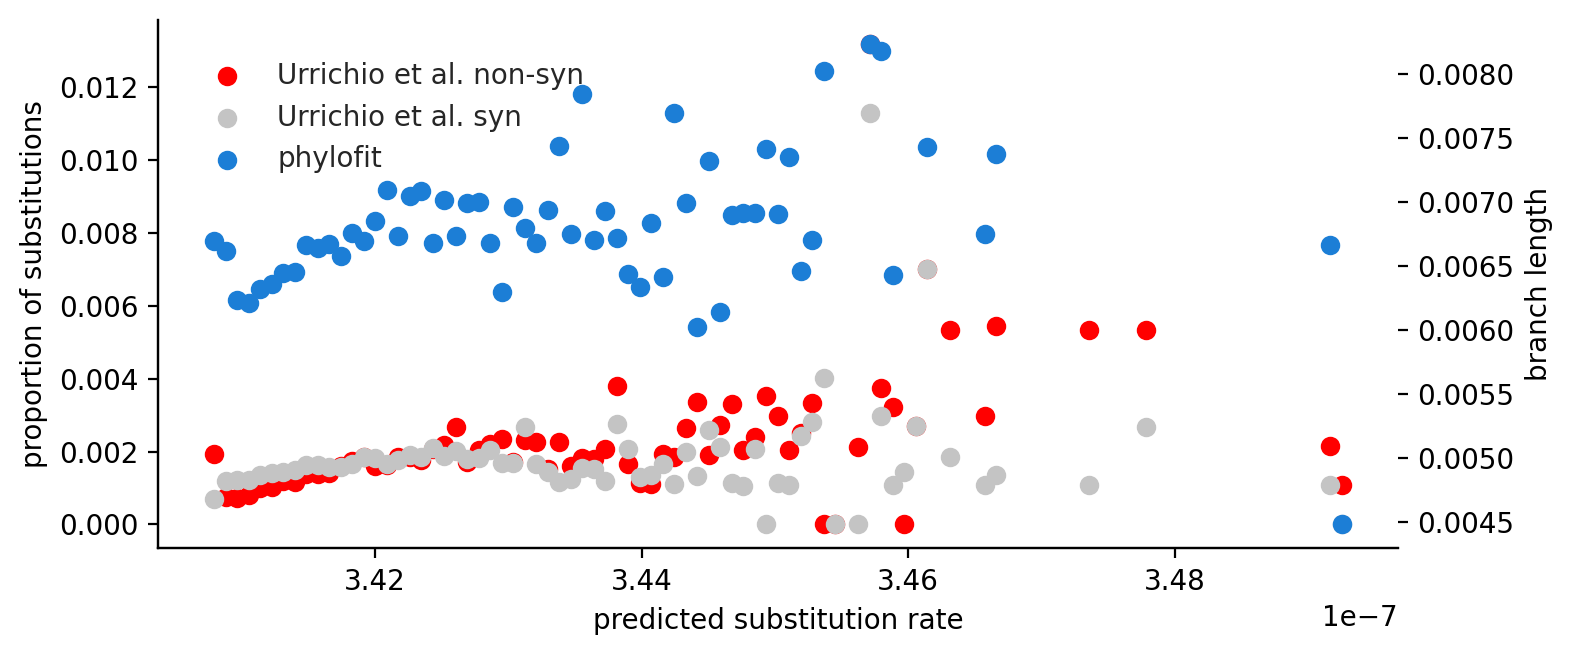

In [58]:


fig, ax = plt.subplots()


ax2 = ax.twinx()
srate_bins = stats.binned_statistic(x, d['nonsyn_prop'], 
                                    statistic=np.nanmean,
                                    bins=bins)

ax.scatter(bin2midpoints(srate_bins), srate_bins.statistic, c='r', label='Urrichio et al. non-syn')

srate_bins = stats.binned_statistic(x, d['syn_prop'], 
                                    statistic=np.nanmean,
                                    bins=bins)
ax.scatter(bin2midpoints(srate_bins), srate_bins.statistic, c='0.77', label='Urrichio et al. syn')



srate_bins = stats.binned_statistic(x, d['branch_length'], 
                                    statistic=np.nanmean,
                                    bins=bins)
ax2.scatter(bin2midpoints(srate_bins), srate_bins.statistic, label='phylofit')


ax2.set_ylabel("branch length")
ax.set_ylabel("proportion of substitutions")
ax.set_xlabel("predicted substitution rate")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax.legend(h1 + h2, l1 + l2, loc='upper left')
#ax.set_xlim(3.407e-7, 3.45e-7)